In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.signal import get_window
from math import sqrt
from utils import *
import time

nbSources = 5
nbChunks = 50
chunkSize = 100
fCarrier = 5000
bandwidth = 2000
snr = 25
nbSnapshots = nbChunks*chunkSize
fmin = fCarrier-bandwidth/2
fmax = fCarrier+bandwidth/2
fSampling = int(3*fmax)
min_distance = (3e8/fmax+1)/2
ref_freq = 5000.0 


def plot_fft_spectrum(signals, fs, legend=True):
    N = signals.shape[1]
    freqs = fftfreq(N, d=1/fs) 
    freqs_shifted = fftshift(freqs)
    spectrum = np.abs(fft(signals, axis=1)) / N
    spectrum_shifted = fftshift(spectrum, axes=1)
    plt.figure(figsize=(10, 4))
    for i in range(signals.shape[0]):
        plt.plot(freqs_shifted, 20 * np.log10(spectrum_shifted[i] + 1e-10), label="Source {}".format(i+1))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid()
    plt.tight_layout()
    if legend: plt.legend()
    plt.show()

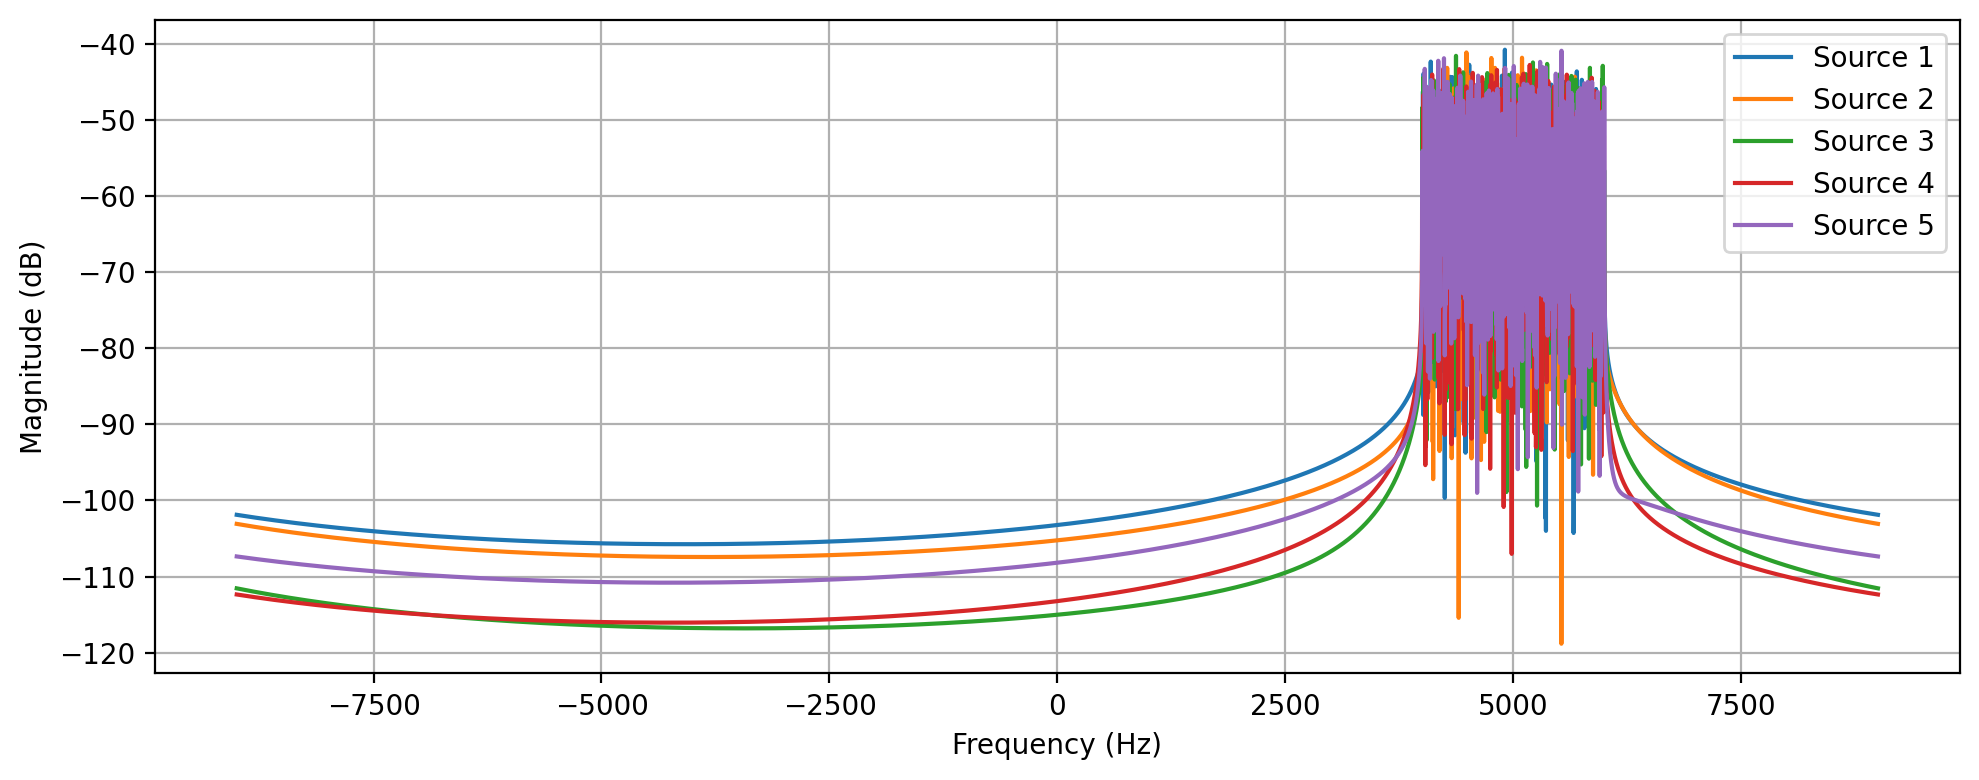

In [2]:
s = generate_ofdm_sources(nbSources, 16384, fSampling, fmin, fmax)
plot_fft_spectrum(s, fSampling)

In [3]:
array = OpenBoxArray(min_distance=min_distance, size_horizontal=34, size_vertical=34)
array.build_coarray()
array.build_array_manifold()
phi = generate_angles(nbSources, 0, np.pi)
theta = generate_angles(nbSources, 0, np.pi/2)
x = array.generate_broadband_data(s, phi, theta, snr, nbSnapshots, fSampling)

Rx, freqs = array.get_covariances(x, nbChunks, fmin, fmax, fSampling, 256)
phi_fft, theta_fft = array.estimate_doa_spatial_fft_robust_autofocusing(Rx, freqs, nbSources, ref_freq, 1024, 1024, 5)
phi_music, theta_music = array.estimate_doa_music_robust_autofocusing(Rx, freqs, nbSources, ref_freq, 5)

# rmspe_func = RMSPE(nbSources)
# rmspe_func.calculate(phi_fft, theta_fft, phi, theta)
# rmspe_func.calculate(phi_music, theta_music, phi, theta)

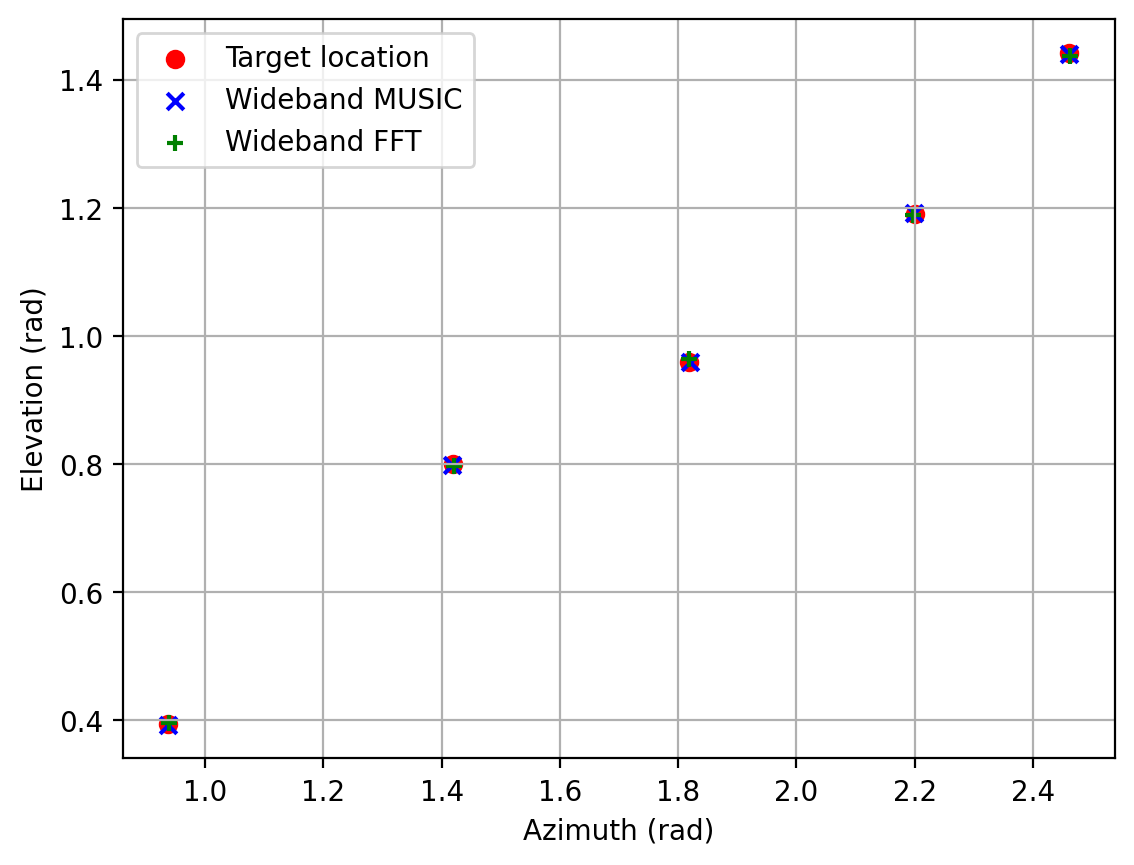

In [4]:
plt.scatter(phi, theta, color='red', marker='o', label="Target location");
plt.scatter(phi_music, theta_music, color='blue', marker='x', label="Wideband MUSIC");
plt.scatter(phi_fft, theta_fft, color='green', marker='+', label="Wideband FFT");
plt.xlabel('Azimuth (rad)')
plt.ylabel('Elevation (rad)')
plt.grid()
plt.legend()
plt.show()